In [1]:
import os, glob, re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import pandas as pd


In [2]:
def get_experiment(hash, experiment_dir):
    path = f"data/{hash}/{experiment_dir}"
    all_data = []
    
    # get all experiment directories
    experiment_dirs = glob.glob(f"{path}/experiment_*")
    
    for exp_dir in experiment_dirs:
        exp_name = os.path.basename(exp_dir)
        session_dirs = glob.glob(f"{exp_dir}/*TrainingSession_*")
        exp_data = {'experiment_name': exp_name}
        
        for session_dir in session_dirs:
            #get first word (e.g., "SNNTrainingSession" -> "SNN")
            session_type = os.path.basename(session_dir).split('Training')[0]            
            
            
            with open(os.path.join(session_dir, "metrics.json"), 'r') as f:
                metrics = json.load(f)
                
                
            #DONT USE THIS! COMPUTE CF METRICS YOURSELF
            with open(os.path.join(session_dir, "cf_metrics.json"), 'r') as f:
                cf_metrics = json.load(f)
            
            #incremental trainer config
            with open(os.path.join(session_dir, "config.json"), 'r') as f:
                config = json.load(f)
                
            #session_hyperparameters
            with open(os.path.join(session_dir, "session_hyperparams.json"), 'r') as f:
                hyperparameters = json.load(f)
            
            
            for k, v in metrics.items():
                exp_data[f"{session_type}_{k}"] = v
            for k, v in cf_metrics.items():
                exp_data[f"{session_type}_{k}"] = v
                
        all_data.append(exp_data)
    
    df = pd.DataFrame(all_data)
    
    return df, config, hyperparameters


In [136]:
def compute_omega_base(alpha_ideal, num_training_sessions, alphas):
    T = num_training_sessions
    omega_base = np.sum(alphas[1:])#skip the first session like in the paper
    omega_base /= ((T-1) * alpha_ideal)
    return omega_base
    
def compute_omega_all(alpha_ideal, num_training_sessions, alphas):
    T = num_training_sessions
    omega_all = np.sum(alphas)
    omega_all /= ((T-1)  * alpha_ideal)
    return omega_all

def compute_omega_new(alpha_ideal, num_training_sessions, alphas):
    T = num_training_sessions
    omega_new = np.sum(alphas)
    omega_new /= (T-1)
    return omega_new

def compute_omega(metric_key, alpha_ideal, num_sessions, baseline_sessions, model_sessions):
    functions = {
        'base': compute_omega_base,
        'all': compute_omega_all,
        'new': compute_omega_new
    }
    func = functions.get(metric_key)
    
    if func:
        baseline_values = np.array(baseline_sessions.apply(lambda x: 
            func(alpha_ideal=alpha_ideal, num_training_sessions=num_sessions, alphas=x)))
        
        values = np.array(model_sessions.apply(lambda x: 
            func(alpha_ideal=alpha_ideal, num_training_sessions=num_sessions, alphas=x)))
        
        return baseline_values, values
    else:
        raise ValueError(f"Unsupported metric: {metric_key}")

def get_cf_metrics(df, model="SNN"):
    metrics_data = []
    alpha_ideal_offline_MLP = df['Baseline_alpha_ideal'].mean()
    
    for metric in ['base', 'new', 'all']:
        all_baseline_alpha_sessions = df[f'Baseline_alpha_{metric}_sessions'].apply(lambda x: np.array(x))
        all_model_alpha_sessions = df[f'{model}_alpha_{metric}_sessions'].apply(lambda x: np.array(x))

        T1 = len(all_baseline_alpha_sessions.iloc[0])
        T2 = len(all_model_alpha_sessions.iloc[0])
        assert T1 == T2, f"Number of training sessions differ: {T1} != {T2}"
        
        baseline_values, values = compute_omega(
            metric, 
            alpha_ideal=alpha_ideal_offline_MLP, 
            num_sessions=T1, 
            baseline_sessions=all_baseline_alpha_sessions, 
            model_sessions=all_model_alpha_sessions
        )
        
        metrics_data.extend([('Ω_' + metric, 'Baseline', v) for v in baseline_values])
        metrics_data.extend([('Ω_' + metric, model, v) for v in values])
    
    plot_df = pd.DataFrame(metrics_data, columns=['Metric', 'Method', 'Value'])
    return plot_df

def plot_cf_metrics(df, model="SNN", title="", ax=None):
    plot_df = get_cf_metrics(df, model)
    
    sns.boxplot(data=plot_df, y='Metric', x='Value', hue='Method', ax=ax, width=0.25,fliersize=2,linewidth=0.5, whis=1.5)
    ax.set_title(f'{model} vs Baseline: {title}')
    
    ax.grid(True, alpha=0.3, linestyle='--')
    #ax.set_xlim(0.1, 1.1) 
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.legend(loc='best')


def plot_session_evolution(df, model="SNN", title="", ax_list=None):
    alpha_ideal_offline_MLP = df['Baseline_alpha_ideal'].mean()
    metrics = ['base', 'new', 'all']
    line_styles = ['-', '-', '-']

    for i, (ax, metric, line_style) in enumerate(zip(ax_list, metrics, line_styles)):
        baseline_alpha_sessions = df[f'Baseline_alpha_{metric}_sessions'].apply(lambda x: np.array(x))
        model_alpha_sessions = df[f'{model}_alpha_{metric}_sessions'].apply(lambda x: np.array(x))

        baseline_alpha_mean = np.mean(np.stack(baseline_alpha_sessions.values), axis=0)
        baseline_alpha_std = np.std(np.stack(baseline_alpha_sessions.values), axis=0)
        
        model_alpha_mean = np.mean(np.stack(model_alpha_sessions.values), axis=0)
        model_alpha_std = np.std(np.stack(model_alpha_sessions.values), axis=0)

        T1 = len(baseline_alpha_mean)
        session_indices = np.arange(1, T1 + 1)
        
        sns.lineplot(ax=ax, x=session_indices, y=baseline_alpha_mean, label='Baseline', linestyle=line_style, marker='o')
        ax.fill_between(session_indices, baseline_alpha_mean - baseline_alpha_std, 
                        baseline_alpha_mean + baseline_alpha_std, alpha=0.2)
        
        sns.lineplot(ax=ax, x=session_indices, y=model_alpha_mean, label=f'{model}', linestyle=line_style, marker='o')
        ax.fill_between(session_indices, model_alpha_mean - model_alpha_std, 
                        model_alpha_mean + model_alpha_std, alpha=0.2)

        ax.axhline(y=alpha_ideal_offline_MLP, color='r', linestyle='--', linewidth=1, label='Alpha Ideal')
        ax.set_title(f'Alpha {metric.capitalize()}')
        ax.set_xlabel('Training Session')
        ax.set_ylabel('Alpha')
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.set_ylim(-0.2, 1.2)
       
        # Show legend only for the first plot in the row
        if i == 0:
            ax.legend(loc='lower left')
        else:
            ax.get_legend().remove()        

### baseline vs SNN

{'replay_buffer_size': 1000, 'incremental_training_size': 1000, 'training_sessions': 6, 'base_classes': [0, 1, 2, 3, 4], 'incremental_classes_total': [5, 6, 7, 8, 9], 'incremental_classes_per_session': 1, 'dataset_name': 'FashionMNIST'}
{'batch_size': 64, 'num_epochs': 1, 'lr': 0.001}
trials=7, dataset=FashionMNIST, batch_size=64, epochs=1, lr=0.001


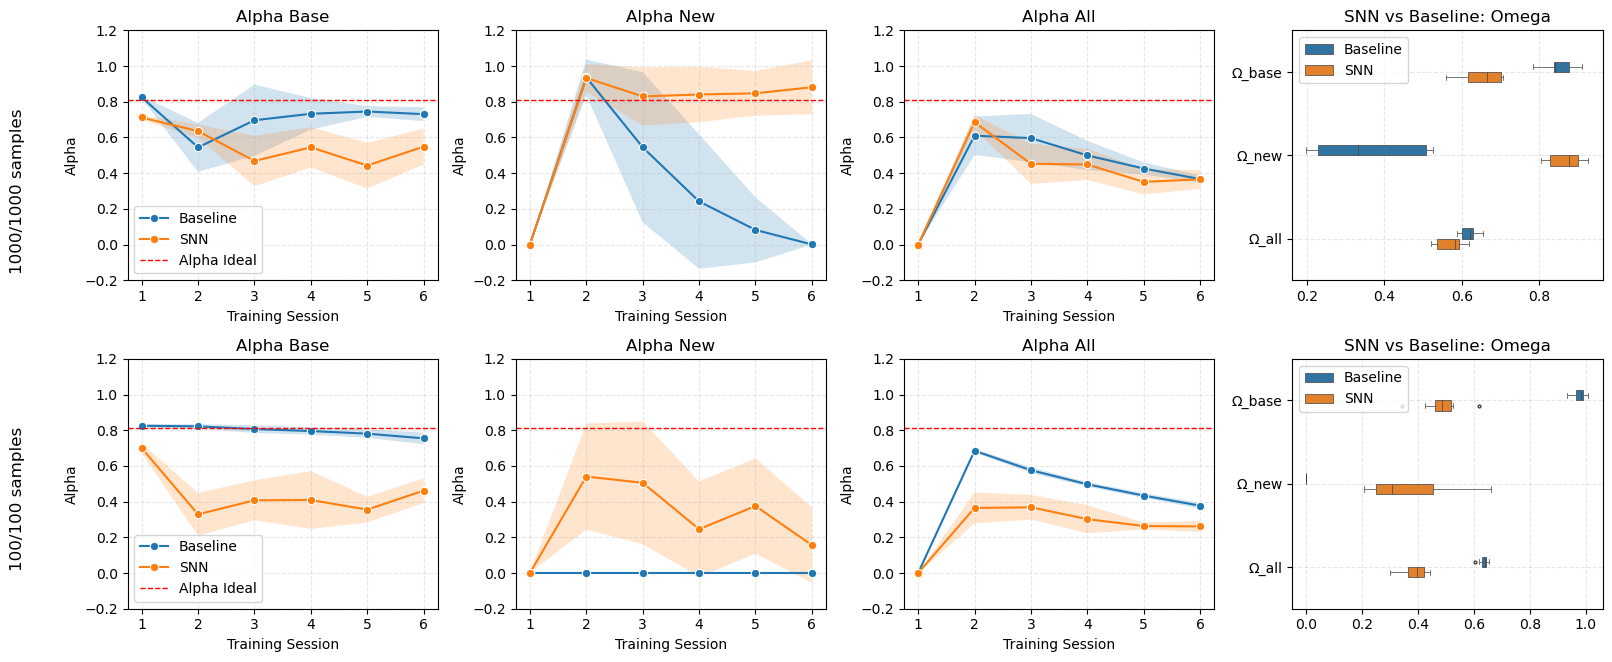

In [137]:
df_snn, snn_config, snn_hyperparameters = get_experiment("accc798", "#2_SNN")
print(snn_config)
print(snn_hyperparameters)
df_snn2, _, _ = get_experiment("accc798", "#2_SNNb")
dfs = [df_snn, df_snn2]

fig, axes = plt.subplots(len(dfs), 4, figsize=(16, 7), sharey='col')
fig.subplots_adjust(hspace=0.7, wspace=0.3)

titles = ["1000/1000 samples", "100/100 samples"]

#overall plot title
#fig.suptitle("CF Performance of Spiking Neural Network", fontsize=16)
#fig.text(0.5, 0.93, f"trials={df_snn.shape[0]}, dataset={snn_config['dataset_name']}, batch_size={snn_hyperparameters['batch_size']}, epochs={snn_hyperparameters['num_epochs']}, lr={snn_hyperparameters['lr']}", ha='center', va='center', size='large')
print(f"trials={df_snn.shape[0]}, dataset={snn_config['dataset_name']}, batch_size={snn_hyperparameters['batch_size']}, epochs={snn_hyperparameters['num_epochs']}, lr={snn_hyperparameters['lr']}")
for i, (df, title) in enumerate(zip(dfs, titles)):
    ax_row = axes[i, :]
    plot_session_evolution(df, model="SNN", title=title, ax_list=ax_row[:-1])
    plot_cf_metrics(df, model="SNN", title="Omega", ax=ax_row[-1])
    
    y_pos = 0.68 - i * 0.44
    fig.text(-0.02, y_pos, title, ha='center', va='center', size='large', rotation=90)

plt.tight_layout(rect=[0, 0, 0.98, 0.96])
plt.show()

#fig.savefig("snn_cf_performance.png")

## baseline vs GA

{'batch_size': 64, 'num_epochs': 1, 'lr': 0.001, 'mutation_rate': 0.1, 'mutation_scale': 0.1, 'crossover_rate': 0.1, 'selection_ratio': [0.5, 0.2, 0.2, 0.1], 'num_generations': 600, 'initial_population_size': 30, 'recall_importance': 0.4, 'parent_selection_strategy': 'combined', 'crossover_strategy': 'random'}
trials=10, dataset=FashionMNIST, batch_size=64, epochs=1, lr=0.001
generations=600, selection_ratio=[0.5, 0.2, 0.2, 0.1], mutation_rate/scale=0.1/0.1, crossover_rate=0.1, recall_importance=0.4


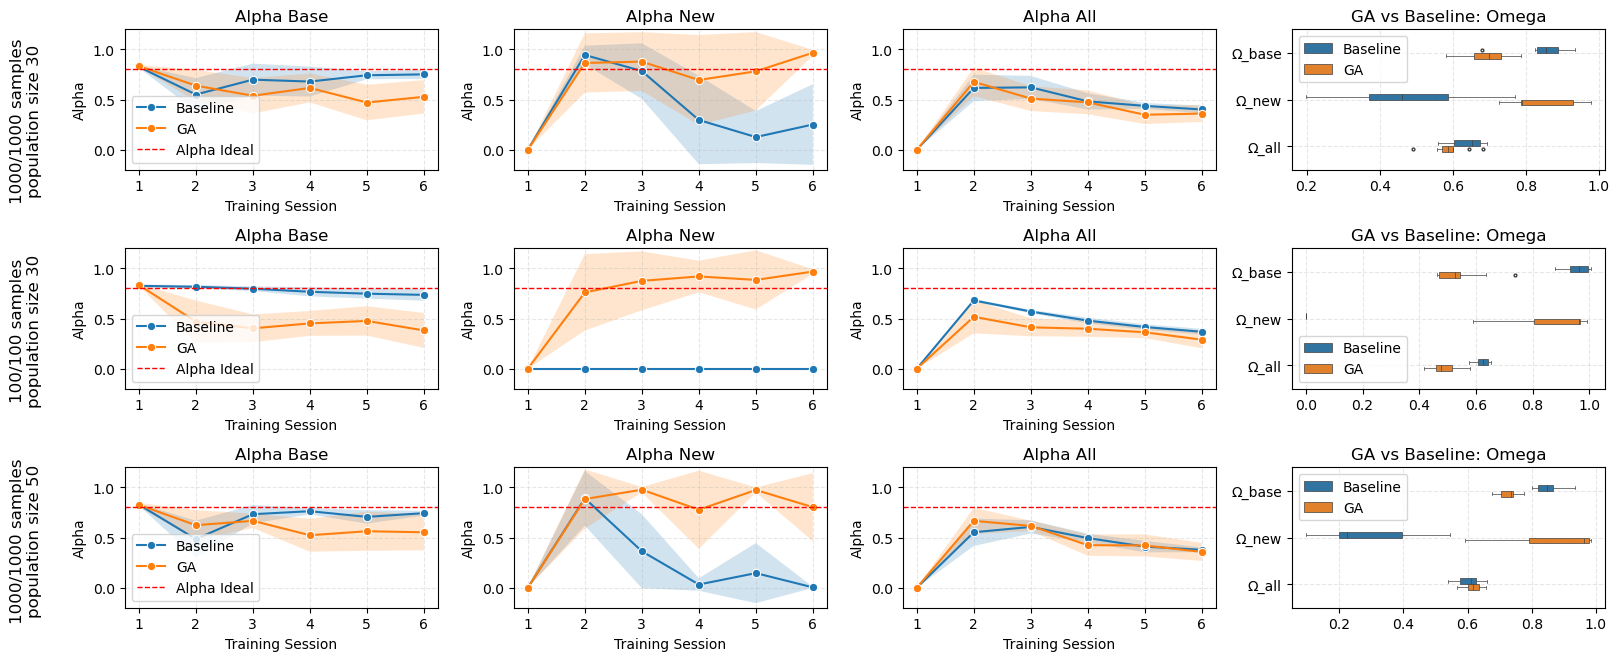

In [138]:
df_ga, ga_config, ga_hyp = get_experiment("e5af9d9", "#1_lasso")
print(ga_hyp)
df_ga2, _,_ = get_experiment("e5af9d9", "#1_16020914_NO")
df_ga3, _,_ = get_experiment("e5af9d9", "#1_16020450_IS")

fig, axes = plt.subplots(3, 4, figsize=(16, 7), sharey='col')
fig.subplots_adjust(hspace=0.7, wspace=0.3)

dfs = [df_ga, df_ga3, df_ga2]
titles = ["1000/1000 samples\npopulation size 30", "100/100 samples\npopulation size 30", "1000/1000 samples\npopulation size 50"]

#overall plot title
#fig.suptitle("CF Performance of Genetic Algorithm", fontsize=14)

#subtitle small
print(f"trials={df_ga.shape[0]}, dataset={ga_config['dataset_name']}, batch_size={ga_hyp['batch_size']}, epochs={ga_hyp['num_epochs']}, lr={ga_hyp['lr']}")
print(f"generations={ga_hyp['num_generations']}, selection_ratio={ga_hyp['selection_ratio']}, mutation_rate/scale={ga_hyp['mutation_rate']}/{ga_hyp['mutation_scale']}, crossover_rate={ga_hyp['crossover_rate']}, recall_importance={ga_hyp['recall_importance']}")
#fig.text(0.5, 0.94, , ha='center', va='center', size='small')
#fig.text(0.5, 0.92, , ha='center', va='center', size='small')

for i, (df, title) in enumerate(zip(dfs, titles)):
    plot_session_evolution(df, model="GA", title=title, ax_list=axes[i, :])
    plot_cf_metrics(df, model="GA", title="Omega", ax=axes[i, -1])
    
    y_pos = 0.78 - i * 0.3  
    fig.text(-0.02, y_pos, title, ha='center', va='center', size='large', rotation=90)

plt.tight_layout(rect=[0, 0, 0.98, 0.96])
plt.show()

#fig.savefig("ga_cf_performance.png")


pygad_fmnist
{'replay_buffer_size': 1000, 'incremental_training_size': 1000, 'training_sessions': 6, 'base_classes': [0, 1, 2, 3, 4], 'incremental_classes_total': [5, 6, 7, 8, 9], 'incremental_classes_per_session': 1, 'dataset_name': 'FashionMNIST', 'enable_progress_bar': False}
{'model_type': "<class 'genetic_algorithms.model.ANN'>", 'transfer': False, 'baseline_model_type': "<class 'genetic_algorithms.model.ANN'>", 'batch_size': 64, 'num_epochs': 1, 'lr': 0.001, 'num_generations': 60, 'num_parents_mating': 5, 'population_size': 1000, 'parent_selection_type': 'sss', 'keep_parents': -1, 'K_tournament': 3, 'crossover_type': 'single_point', 'mutation_type': 'random', 'mutation_percent_genes': 10.0, 'mutation_by_replacement': False, 'random_mutation_min_val': -0.1, 'random_mutation_max_val': 0.1, 'fitness_batch_size': 1000, 'slurm': True}
pygad_fmnist_ann_1000pop_200gen
{'replay_buffer_size': 1000, 'incremental_training_size': 1000, 'training_sessions': 6, 'base_classes': [0, 1, 2, 3, 4],

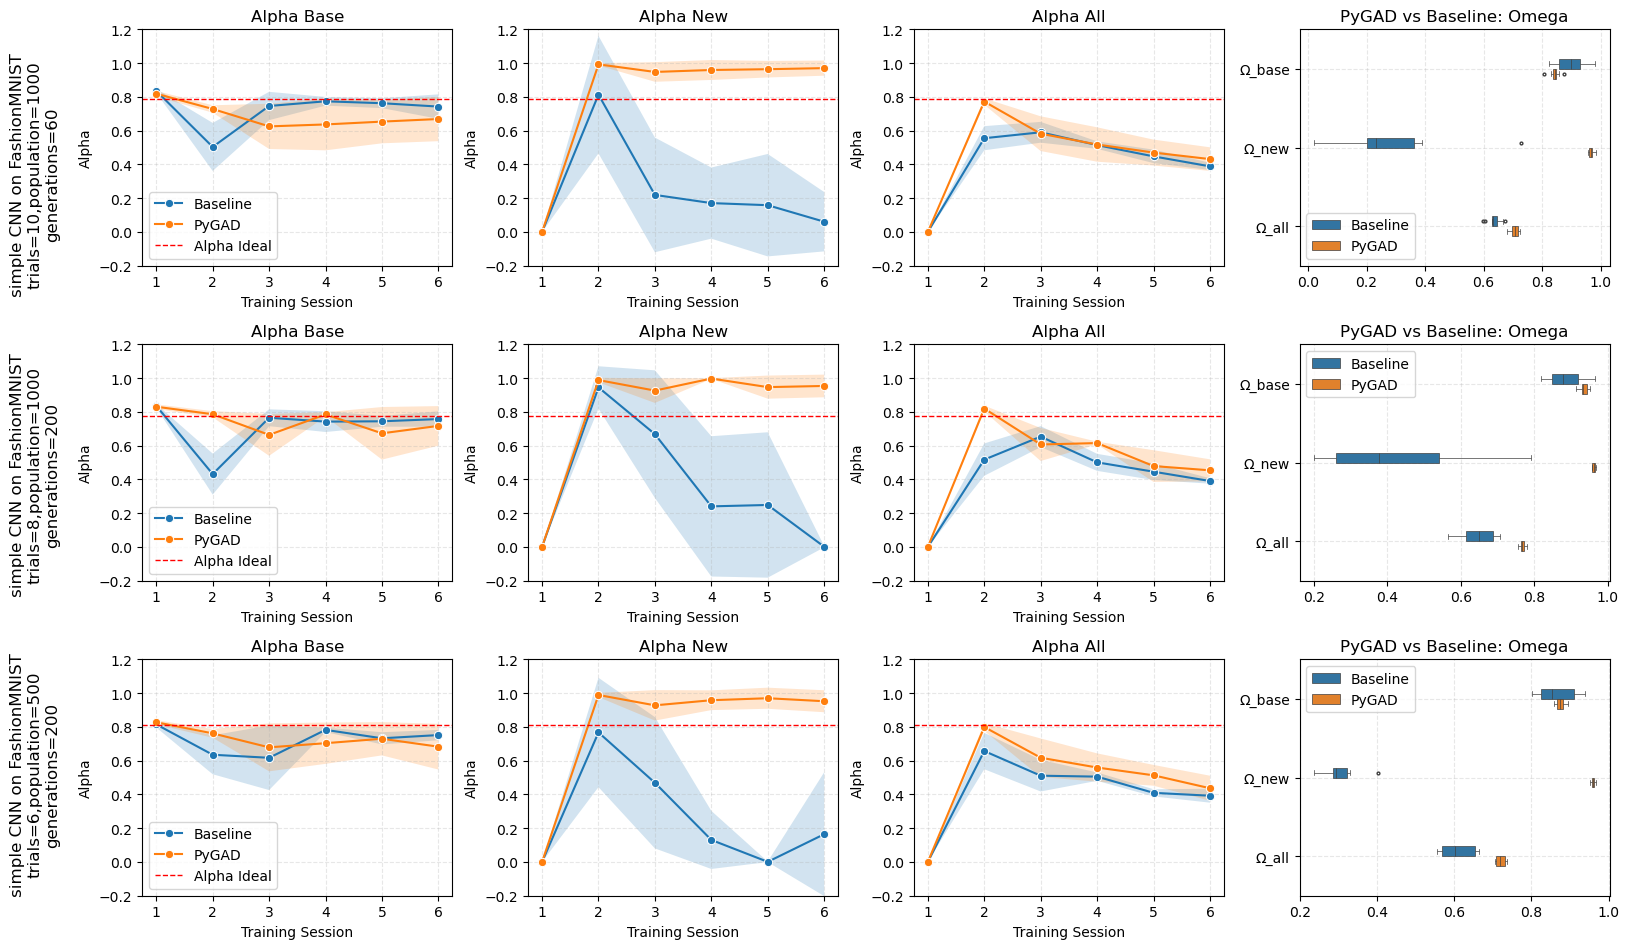

In [146]:

df_pygad, pygad_config, pygad_hyp = get_experiment("yi", "pygad_fmnist")
df_pygad2, pygad2_config, pygad2_hyp = get_experiment("yi", "pygad_fmnist_ann_1000pop_200gen")
df_pygad2b, pygad_config2b, pygad_hyp2b = get_experiment("yi", "pygad_fmnist_ann_500pop_200gen")
df_pygad3, pygad3_config, pygad3_hyp = get_experiment("yi", "pygad_cifar10_ann_1000pop_100gen")

print("pygad_fmnist")
print(pygad_config)
print(pygad_hyp)
print("pygad_fmnist_ann_1000pop_200gen")
print(pygad2_config)
print(pygad2_hyp)
print("pygad_fmnist_ann_500pop_200gen")
print(pygad_config2b)
print(pygad_hyp2b)
print("pygad_cifar10_ann_1000pop_100gen")
print(pygad3_config)
print(pygad3_hyp)


fig, axes = plt.subplots(3, 4, figsize=(16, 10), sharey='col')
fig.subplots_adjust(hspace=0.7, wspace=0.3)

dfs = [df_pygad, df_pygad2, df_pygad2b]
titles = [f"simple CNN on FashionMNIST\ntrials={df_pygad.shape[0]},population={pygad_hyp['population_size']}\ngenerations={pygad_hyp['num_generations']}", 
          f"simple CNN on FashionMNIST\ntrials={df_pygad2.shape[0]},population={pygad2_hyp['population_size']}\ngenerations={pygad2_hyp['num_generations']}",
          f"simple CNN on FashionMNIST\ntrials={df_pygad2b.shape[0]},population={pygad_hyp2b['population_size']}\ngenerations={pygad_hyp2b['num_generations']}"]

#overall plot title
#fig.suptitle("CF Performance of PyGAD", fontsize=16)
#fig.text(0.5, 0.93, f"1000/1000 samples, parents_mating=5, selection=sss, K_tournament=3, crossover=single, random_mutation=±0.1, keep_parents=-1", ha='center', va='center', size='large')
print(f"1000/1000 samples, parents_mating=5, selection=sss, K_tournament=3, crossover=single, random_mutation=±0.1, keep_parents=-1")
for i, (df, title) in enumerate(zip(dfs, titles)):
    plot_session_evolution(df, model="PyGAD", title=title, ax_list=axes[i, :])
    plot_cf_metrics(df, model="PyGAD", title="Omega", ax=axes[i, -1])
    
    y_pos = 0.78 - i * 0.3
    fig.text(-0.02, y_pos, title, ha='center', va='center', size='large', rotation=90)

plt.tight_layout(rect=[0, 0, 0.98, 0.96])
plt.show()

#fig.savefig("pygad_cf_performance.png")

pygad_cifar10_ann_1000pop_100gen
{'replay_buffer_size': 1000, 'incremental_training_size': 1000, 'training_sessions': 6, 'base_classes': [0, 1, 2, 3, 4], 'incremental_classes_total': [5, 6, 7, 8, 9], 'incremental_classes_per_session': 1, 'dataset_name': 'FashionMNIST', 'enable_progress_bar': False}
{'model_type': "<class 'genetic_algorithms.model.ANN'>", 'transfer': False, 'baseline_model_type': "<class 'genetic_algorithms.model.ANN'>", 'batch_size': 64, 'num_epochs': 1, 'lr': 0.001, 'num_generations': 100, 'num_parents_mating': 5, 'population_size': 1000, 'parent_selection_type': 'sss', 'keep_parents': -1, 'K_tournament': 3, 'crossover_type': 'single_point', 'mutation_type': 'random', 'mutation_percent_genes': 10.0, 'mutation_by_replacement': False, 'random_mutation_min_val': -0.1, 'random_mutation_max_val': 0.1, 'fitness_batch_size': 1000, 'slurm': True}
pygad_cifar10_resnet18_100pop_70gen_fixed
{'replay_buffer_size': 1000, 'incremental_training_size': 1000, 'training_sessions': 6, '

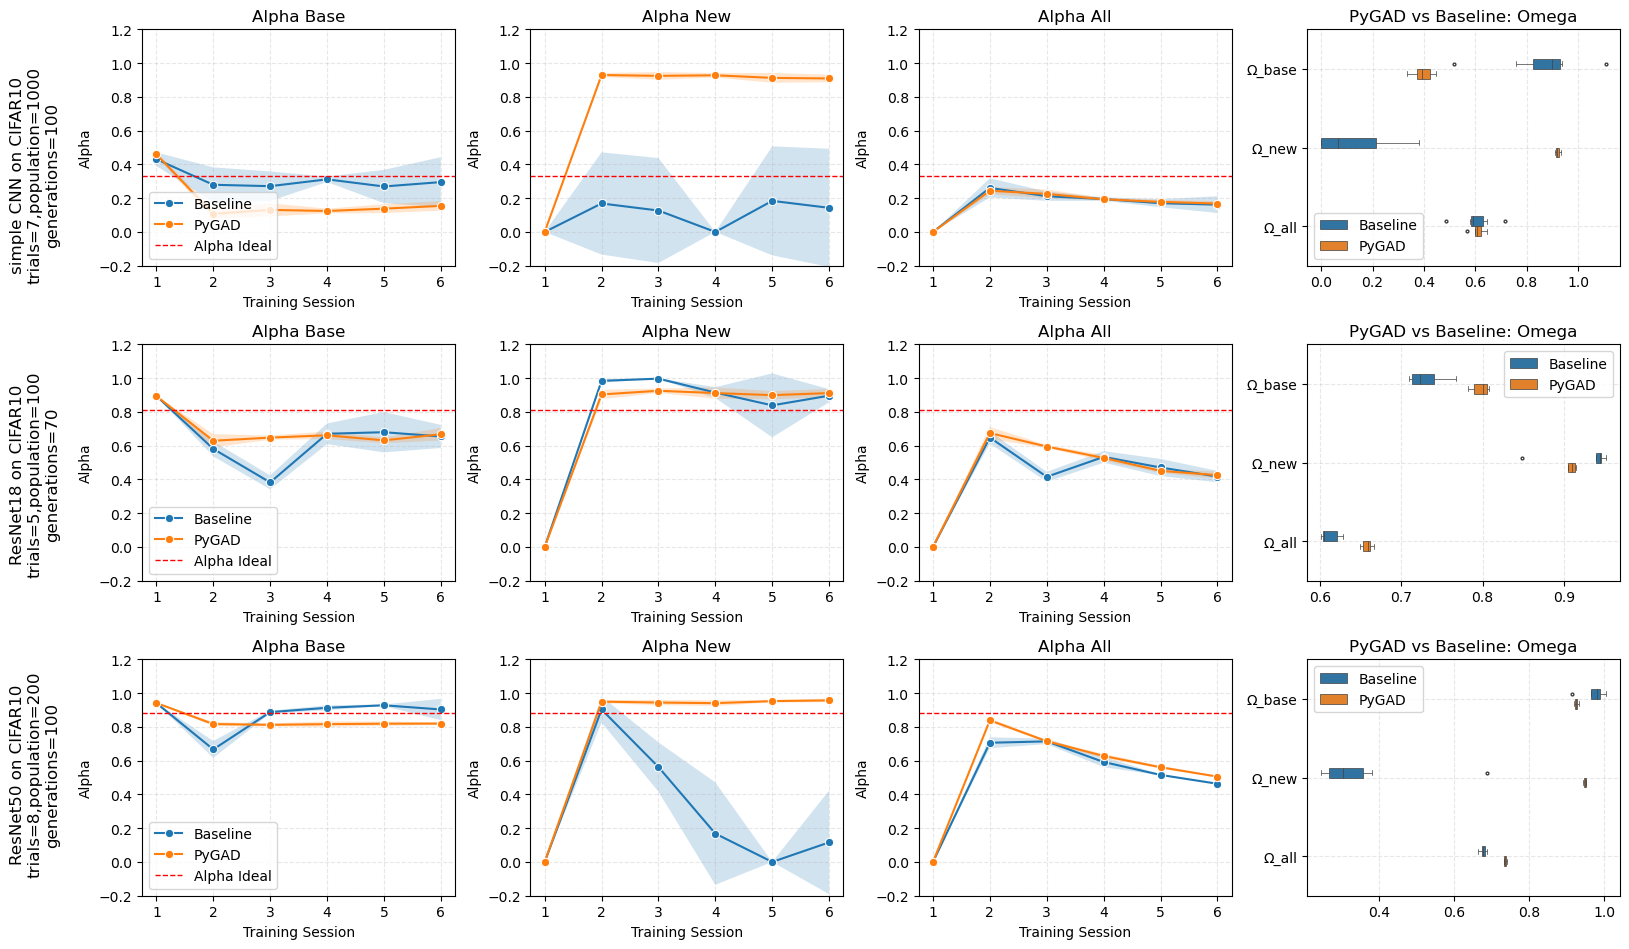

In [150]:
df_pygad3, pygad3_config, pygad3_hyp = get_experiment("yi", "pygad_cifar10_ann_1000pop_100gen")
df_pygad4, pygad4_config, pygad4_hyp = get_experiment("yi", "pygad_cifar10_resnet18_100pop_70gen_fixed")
df_pygad5, pygad5_config, pygad5_hyp = get_experiment("yi", "pygad_cifar10_resnet50_200pop_100gen")

print("pygad_cifar10_ann_1000pop_100gen")
print(pygad3_config)
print(pygad3_hyp)
print("pygad_cifar10_resnet18_100pop_70gen_fixed")
print(pygad4_config)
print(pygad4_hyp)
print("pygad_cifar10_resnet50_200pop_100gen")
print(pygad5_config)
print(pygad5_hyp)

fig, axes = plt.subplots(3, 4, figsize=(16, 10), sharey='col')
fig.subplots_adjust(hspace=0.7, wspace=0.3)

dfs = [df_pygad3, df_pygad4, df_pygad5]
titles = [
          f"simple CNN on CIFAR10\ntrials={df_pygad3.shape[0]},population={pygad3_hyp['population_size']}\ngenerations={pygad3_hyp['num_generations']}",
            f"ResNet18 on CIFAR10\ntrials={df_pygad4.shape[0]},population={pygad4_hyp['population_size']}\ngenerations={pygad4_hyp['num_generations']}",
            f"ResNet50 on CIFAR10\ntrials={df_pygad5.shape[0]},population={pygad5_hyp['population_size']}\ngenerations={pygad5_hyp['num_generations']}"
          ]

#overall plot title
#fig.suptitle("CF Performance of PyGAD", fontsize=16)
#fig.text(0.5, 0.93, f"1000/1000 samples, parents_mating=5, selection=sss, K_tournament=3, crossover=single, random_mutation=±0.1, keep_parents=-1", ha='center', va='center', size='large')
print(f"1000/1000 samples, parents_mating=5, selection=sss, K_tournament=3, crossover=single, random_mutation=±0.1, keep_parents=-1")
for i, (df, title) in enumerate(zip(dfs, titles)):
    plot_session_evolution(df, model="PyGAD", title=title, ax_list=axes[i, :])
    plot_cf_metrics(df, model="PyGAD", title="Omega", ax=axes[i, -1])
    
    y_pos = 0.78 - i * 0.3
    fig.text(-0.02, y_pos, title, ha='center', va='center', size='large', rotation=90)

plt.tight_layout(rect=[0, 0, 0.98, 0.96])
plt.show()

#fig.savefig("pygad_cf_performance.png")

## Results table

In [151]:
df_snn, snn_config, snn_hyperparameters = get_experiment("accc798", "#2_SNN")
df_snn2, _, _ = get_experiment("accc798", "#2_SNNb")

df_ga, ga_config, ga_hyp = get_experiment("e5af9d9", "#1_lasso")
df_ga2, _,_ = get_experiment("e5af9d9", "#1_16020914_NO")
df_ga3, _,_ = get_experiment("e5af9d9", "#1_16020450_IS")

df_pygad, pygad_config, pygad_hyp = get_experiment("yi", "pygad_fmnist")
df_pygad2, pygad_config2, pygad_hyp2 = get_experiment("yi", "pygad_fmnist_ann_1000pop_200gen")
df_pygad2b, pygad_config2b, pygad_hyp2b = get_experiment("yi", "pygad_fmnist_ann_500pop_200gen")


df_pygad3, pygad_config3, pygad_hyp3 = get_experiment("yi", "pygad_cifar10_ann_1000pop_100gen")
df_pygad4, pygad_config4, pygad_hyp4 = get_experiment("yi", "pygad_cifar10_resnet18_100pop_70gen_fixed")
df_pygad5, pygad_config5, pygad_hyp5 = get_experiment("yi", "pygad_cifar10_resnet50_200pop_100gen")

#results table for the paper

# model, hyperparams, dataset, omega_base, omega_new, omega_all

snn = {
    "model:simple CNN,params:1000/1000 samples,ds:FashionMNIST":get_cf_metrics(df_snn, model="SNN").groupby(['Method','Metric']).mean().round(3), 
    "model:simple CNN,params:100/100 samples,ds:FashionMNIST":get_cf_metrics(df_snn2, model="SNN").groupby(['Method','Metric']).mean().round(3)
    }

ga = {
    "model:simple CNN,params:1000/1000 samples\npopulation size 30,ds:FashionMNIST":get_cf_metrics(df_ga, model="GA").groupby(['Method','Metric']).mean().round(3),
    "model:simple CNN,params:100/100 samples\npopulation size 30,ds:FashionMNIST":get_cf_metrics(df_ga3, model="GA").groupby(['Method','Metric']).mean().round(3),
    "model:simple CNN,params:1000/1000 samples\npopulation size 50,ds:FashionMNIST":get_cf_metrics(df_ga2, model="GA").groupby(['Method','Metric']).mean().round(3)
    }

pygad = {
    "model:simple CNN,ds:FashionMNIST,p=1000,60 generations":get_cf_metrics(df_pygad, model="PyGAD").groupby(['Method','Metric']).mean().round(3),
    "model:simple CNN,ds:FashionMNIST,p=1000,200 generations":get_cf_metrics(df_pygad2, model="PyGAD").groupby(['Method','Metric']).mean().round(3),
    "model:simple CNN,ds:FashionMNIST,p=1000,100 generations":get_cf_metrics(df_pygad2b, model="PyGAD").groupby(['Method','Metric']).mean().round(3),
    "model:simple CNN,ds:CIFAR10,p=1000,100 generations":get_cf_metrics(df_pygad3, model="PyGAD").groupby(['Method','Metric']).mean().round(3),
    "model:ResNet18,ds:CIFAR10,p=100,70 generations":get_cf_metrics(df_pygad4, model="PyGAD").groupby(['Method','Metric']).mean().round(3),
    "model:ResNet50,ds:CIFAR10,p=200,100 generations":get_cf_metrics(df_pygad5, model="PyGAD").groupby(['Method','Metric']).mean().round(3)
    }


In [45]:
ga

{'model:simple CNN,params:1000/1000 samples\npopulation size 30,ds:FashionMNIST':                  Value
 Method   Metric       
 Baseline Ω_all   0.636
          Ω_base  0.851
          Ω_new   0.480
 GA       Ω_all   0.589
          Ω_base  0.694
          Ω_new   0.837,
 'model:simple CNN,params:100/100 samples\npopulation size 30,ds:FashionMNIST':                  Value
 Method   Metric       
 Baseline Ω_all   0.621
          Ω_base  0.956
          Ω_new   0.000
 GA       Ω_all   0.490
          Ω_base  0.539
          Ω_new   0.882,
 'model:simple CNN,params:1000/1000 samples\npopulation size 50,ds:FashionMNIST':                  Value
 Method   Metric       
 Baseline Ω_all   0.606
          Ω_base  0.852
          Ω_new   0.287
 GA       Ω_all   0.617
          Ω_base  0.727
          Ω_new   0.883}

In [152]:
pygad

{'model:simple CNN,ds:FashionMNIST,p=1000,60 generations':                  Value
 Method   Metric       
 Baseline Ω_all   0.635
          Ω_base  0.897
          Ω_new   0.285
 PyGAD    Ω_all   0.705
          Ω_base  0.842
          Ω_new   0.967,
 'model:simple CNN,ds:FashionMNIST,p=1000,200 generations':                  Value
 Method   Metric       
 Baseline Ω_all   0.647
          Ω_base  0.887
          Ω_new   0.421
 PyGAD    Ω_all   0.767
          Ω_base  0.935
          Ω_new   0.962,
 'model:simple CNN,ds:FashionMNIST,p=1000,100 generations':                  Value
 Method   Metric       
 Baseline Ω_all   0.609
          Ω_base  0.865
          Ω_new   0.306
 PyGAD    Ω_all   0.720
          Ω_base  0.875
          Ω_new   0.959,
 'model:simple CNN,ds:CIFAR10,p=1000,100 generations':                  Value
 Method   Metric       
 Baseline Ω_all   0.604
          Ω_base  0.862
          Ω_new   0.125
 PyGAD    Ω_all   0.610
          Ω_base  0.395
          Ω_new   0.921

In [49]:
snn

{'model:simple CNN,params:1000/1000 samples,ds:FashionMNIST':                  Value
 Method   Metric       
 Baseline Ω_all   0.617
          Ω_base  0.852
          Ω_new   0.361
 SNN      Ω_all   0.569
          Ω_base  0.652
          Ω_new   0.866,
 'model:simple CNN,params:100/100 samples,ds:FashionMNIST':                  Value
 Method   Metric       
 Baseline Ω_all   0.633
          Ω_base  0.976
          Ω_new   0.000
 SNN      Ω_all   0.384
          Ω_base  0.484
          Ω_new   0.365}